In [13]:
from contrastive import CPCA
from copy import copy
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from pyensembl import ensembl_grch38
from rpca import R_pca
import scipy
from scipy.linalg import svd
from sklearn.decomposition import PCA, SparsePCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import label_binarize
from supervisedPCA import supervised_pca
import time

In [14]:
# Utility functions.
def to_one_hot_one_feature(U):
    """ Assumes U has a single feature.
    Returns matrix of size U.shape[0], number_unique + 1
    """
    as_set = set(U)
    print(as_set)
    set_as_list = list(as_set)
    one_hot = np.zeros((U.shape[0], len(as_set)))
    for i in range(U.shape[0]):
        one_hot[i, set_as_list.index(U[i])] = 1
    return one_hot

def load_data(data_dir, split_by):
    fg_data = np.load("{}cases.npy".format(data_dir))
    bg_data = np.load("{}controls.npy".format(data_dir))
    matches = np.load("{}matches.npy".format(data_dir))
    try:
        stages  = np.load("{}cases_stages.npy".format(data_dir))
    except FileNotFoundError:
        stages = np.array([])
    if split_by == "Stage":
        bg_data = np.squeeze(fg_data[np.where(stages == "stage iv"), :])
        fg_data = np.squeeze(fg_data[np.where(stages == "stage i"), :])
        print(bg_data.shape)
        print(fg_data.shape)
        matches = []
        fname_base = "stage"
    return fg_data, bg_data, matches, stages

In [15]:
plt.rcParams['savefig.dpi'] = 300
cancer_type = "GBM"
split_by = "Case_Control"

test_case_control = True
test_tissue_type = False

if test_tissue_type:
    fname_base = "tissue_type"
elif test_case_control:
    fname_base = "case_control"
else:
    fname_base = "stage"

plot_clusters = True
calc_onc_selection = True
plot_selection = (True and calc_onc_selection)
write_enrichment = True
plot_singular_values = False

add_unmatched = cancer_type in ["GBM", "Combined"] # only add unmatched for GBM/combined due to lack of matched samples
pct_train = 0.6
split_in_order = False

In [16]:
data_dir = "{}/".format(cancer_type)
foreground_data, background_data, matches, stages = load_data(data_dir, split_by)
n_fg = len(foreground_data)
n_bg = len(background_data)
transcript_names = np.load("transcript_names.npy")
print(n_fg, n_bg, len(transcript_names))

312 10 60483


In [17]:
# Convert transcript names into gene names.
transcript_names_converted = []
class Nil(object):
    pass
not_found = Nil()
not_found.gene_name = "Not Found"
for i, t_id in enumerate(transcript_names):
    try:
        transcript_names_converted.append(ensembl_grch38.gene_by_id(t_id[2:-3]))
    except ValueError:
        transcript_names_converted.append(not_found)
        foreground_data[:, i] = 0.
        background_data[:, i] = 0.
transcript_names = np.array(transcript_names_converted)

In [18]:
# Organize data.
fg_mask = np.std(foreground_data, axis=0) > 1e-1
bg_mask = np.std(background_data, axis=0) > 1e-1
mask = np.logical_and(fg_mask, bg_mask)
name_mask = np.array([x != not_found for x in transcript_names])
mask = np.logical_and(mask, name_mask)
foreground_data = foreground_data[:, mask]
background_data = background_data[:, mask]
transcript_names = transcript_names[mask]
n_transcripts = 50000
foreground_data = foreground_data[:, :n_transcripts]
background_data = background_data[:, :n_transcripts]
transcript_names = transcript_names[:n_transcripts]
print(foreground_data.shape)
print(background_data.shape)

from sklearn.preprocessing import normalize
combined = np.vstack((foreground_data, background_data))
combined_normed = normalize(combined, axis=1)
combined_normed = normalize(combined_normed, axis=0)
del combined
foreground_data = combined_normed[:n_fg]
background_data = combined_normed[n_fg:]

if split_in_order:
    n_train_fg = int(pct_train*n_fg)
    n_train_bg = int(pct_train*n_bg)
    n_train_fg = len(fg_data_brca)
    n_train_bg = len(bg_data_brca)
    train_fg_idxs = np.array(range(n_train_fg))
    train_bg_idxs = np.array(range(n_train_bg))
    test_fg_idxs  = np.array(range(n_train_fg, n_fg))
    test_bg_idxs  = np.array(range(n_train_bg, n_bg))
    n_test_fg = len(test_fg_idxs)
    n_test_bg = len(test_bg_idxs)
else:
    train_fg_idxs, test_fg_idxs = train_test_split(list(range(n_fg)), test_size=1-pct_train)
    train_bg_idxs, test_bg_idxs = train_test_split(list(range(n_bg)), test_size=1-pct_train)
    n_train_fg = len(train_fg_idxs)
    n_test_fg  = len(test_fg_idxs)
    n_train_bg = len(train_bg_idxs)
    n_test_bg  = len(test_bg_idxs)

(312, 30584)
(10, 30584)


In [19]:
max_n_components = 25
train_fg = foreground_data[train_fg_idxs]
train_bg = background_data[train_bg_idxs]
test_fg  = foreground_data[test_fg_idxs]
test_bg  = background_data[test_bg_idxs]
train_data = np.vstack((train_fg, train_bg))
test_data  = np.vstack((test_fg,  test_bg))
train_labels = np.ravel(np.vstack((np.ones((n_train_fg, 1)), np.zeros((n_train_bg, 1)))))
test_labels = np.ravel(np.vstack((np.ones((n_test_fg, 1)), np.zeros((n_test_bg, 1)))))

In [20]:
# Make differential dataset
differential = np.zeros((1, foreground_data.shape[1]))
if len(matches) > 0:
    print("****Matched****")
    differential = np.array([foreground_data[i] - background_data[j] for [j, i] in matches if i in train_fg_idxs and j in train_bg_idxs])
    differential = np.vstack((differential, np.zeros_like(differential)))
if add_unmatched:
    n_differential = 750
    print("****Adding {} unmatched differences****".format(n_differential))
    unmatched = np.array([foreground_data[np.random.choice(train_fg_idxs)] - background_data[np.random.choice(train_bg_idxs)] for _ in range(n_differential)])
    unmatched = np.vstack((unmatched, np.zeros_like(unmatched)))
    differential = np.vstack((differential, unmatched))

differential = normalize(differential, axis=1)
differential = normalize(differential, axis=0)

****Adding 750 unmatched differences****


In [21]:
if cancer_type == "Combined":
    train_cancer_types = cancer_types_fg[train_fg_idxs]
    test_cancer_types  = cancer_types_fg[test_fg_idxs]

if not test_case_control and not test_tissue_type:
    stages_parsed = np.zeros((len(stages), 5))
    for i, stage in enumerate(stages):
        stage = stage[0]
        if "stage iv" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 0, 0, 1])
        elif "stage iii" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 0, 1, 0])
        elif "stage ii" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 1, 0, 0])
        elif "stage i" in stage.lower():
            stages_parsed[i, :] = np.array([0, 1, 0, 0, 0])
        else:
            stages_parsed[i, :] = np.array([1, 0, 0, 0, 0])

    stages = stages_parsed
    train_stages = stages[train_fg_idxs]
    test_stages  = stages[test_fg_idxs]
    train_stages = np.argmax(train_stages, axis=1)
    test_stages = np.argmax(test_stages, axis=1)
    print(train_stages.shape)
    print(test_stages.shape)

def get_differential(data, numComponents=None):
        m, n = data.shape
        data -= data.mean(axis=0)

        pca = PCA(n_components=numComponents)
        data_components = pca.fit_transform(data)
        return data_components, pca.singular_values_, pca.components_.T
        """
        print("Calculating cov")
        R = np.cov(data, rowvar=False)
        print("Finished cov")
        # use 'eigh' rather than 'eig' since R is symmetric,
        # the performance gain is substantial
        evals, evecs = np.linalg.eigh(R)
        print("Finished eigh.")
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        evals = evals[idx]
        if numComponents is not None:
            evecs = evecs[:, :numComponents]
        # carry out the transformation on the data using eigenvectors
        # and return the re-scaled data, eigenvalues, and eigenvectors
        return np.dot(evecs.T, data.T).T, evals, evecs
        """

In [24]:
# Fit All Dim Reduction Methods.

# Normal PCA
print("Fitting PCA...", end='')
t = time.time()
pca = PCA(n_components=max_n_components)
pca_train_reduced = pca.fit_transform(train_data)
print("Took {:.3f} seconds".format(time.time() - t))
pca_test_reduced = pca.transform(test_data)
pca_components = pca.components_
pca_sing = pca.singular_values_


print("Fitting ICA...", end='')
t = time.time()
ica = FastICA(n_components=max_n_components, whiten=True)
print(train_data.shape)
ica_train_reduced = ica.fit_transform(train_data)
print("Took {:.3f} seconds".format(time.time() - t))
ica_test_reduced  = ica.transform(test_data)
ica_components    = ica.components_.copy()

print("Fitting CCA...", end='')
import sys
t = time.time()
from sklearn.cross_decomposition import CCA
ccas = []
cca_train_reduced = np.zeros((train_data.shape[0], max_n_components))
cca_components    = np.zeros((max_n_components, train_data.shape[1]))
cur_reps_cca      = np.zeros_like(train_data)
for i in range(max_n_components):
    sys.stdout.flush()
    print(i, end='')
    cca = CCA(n_components=1, scale=True)
    data_to_reduce = train_data-cur_reps_cca
    if data_to_reduce.shape[1] > 50:
        pca_cca = PCA(n_components=50)
        data_to_reduce = pca_cca.fit_transform(data_to_reduce)
    cca.fit(data_to_reduce, train_labels)
    cca_components[i, :] = np.squeeze(cca.x_weights_.T.dot(pca_cca.components_))
    cca_train_reduced[:, i] = np.squeeze(train_data.dot(np.expand_dims(cca_components[i, :], 1)))
    cur_reps_cca += np.expand_dims(cca_train_reduced[:, i], 1).dot(np.expand_dims(cca_components[i, :], 1).T)
    ccas.append(copy(cca))
print("Took {:.3f} seconds".format(time.time() - t))
cca_test_reduced  = np.array([np.squeeze(test_data.dot(np.expand_dims(cca_components[i, :], 1))) for i in range(max_n_components)]).T

print("Fitting LDA...", end='')
t = time.time()
ldas = []
pca_ldas = []
lda_train_reduced = np.zeros((train_data.shape[0], max_n_components))
lda_components    = np.zeros((max_n_components, train_data.shape[1]))
cur_reps_lda      = np.zeros_like(train_data)
for i in range(max_n_components):
    sys.stdout.flush()
    print(i, end='')
    lda = LDA(n_components=1)
    data_to_reduce = train_data-cur_reps_lda
    if data_to_reduce.shape[1] > 100:
        pca_lda = PCA(n_components=100)
        data_to_reduce = pca_lda.fit_transform(data_to_reduce)
        pca_ldas.append(pca_lda)
    lda_train_reduced[:, i] = np.squeeze(lda.fit_transform(data_to_reduce, train_labels))
    lda_components[i, :]    = lda.scalings_.T.dot(pca_lda.components_)
    cur_reps_lda += np.expand_dims(lda_train_reduced[:, i], 1).dot(np.expand_dims(lda_components[i, :], 1).T)
    ldas.append(copy(lda))
print("Took {:.3f} seconds".format(time.time() - t))
lda_test_reduced  = np.zeros((test_data.shape[0], max_n_components))
cur_reps = np.zeros_like(test_data)
for i in range(max_n_components):
    lda_test_reduced[:, i] = np.squeeze(ldas[i].transform(pca_ldas[i].transform(test_data - cur_reps)))
    cur_reps += np.expand_dims(lda_test_reduced[:, i], 1).dot(np.expand_dims(lda_components[i, :], 1).T)

print("Fitting SupPCA...", end='')
t = time.time()
sup_pca = supervised_pca.SupervisedPCAClassifier(n_components=max_n_components)
sup_pca.fit(train_data, train_labels)
sup_train_reduced = sup_pca.get_transformed_data(train_data)
sup_test_reduced  = sup_pca.get_transformed_data(test_data)
sup_components    = sup_pca.get_components()
print("Took {:.3f} seconds".format(time.time() - t))

print("Fitting PLS...", end='')
t = time.time()
plsr = PLSRegression(n_components=max_n_components, scale=True)
plsr.fit(train_data, train_labels)
plsr_train_reduced = plsr.x_scores_
plsr_test_reduced  = plsr.transform(test_data)
plsr_components    = plsr.x_weights_.T # n_components x n_features
print("Took {:.3f} seconds".format(time.time() - t))

# Contrastive PCA
print("Fitting cPCA...", end='')
t = time.time()
mdl = CPCA(n_components=max_n_components)
cpca_preprocess = PCA(n_components=500)
train_data_preprocessed = cpca_preprocess.fit_transform(train_data)
test_data_preprocessed = cpca_preprocess.transform(test_data)
cpca_preprocess_components = cpca_preprocess.components_.copy()
cpca_train_fg_reduced, alpha = mdl.fit_transform(train_data_preprocessed[:n_train_fg], train_data_preprocessed[n_train_fg:],
    n_alphas=1, n_alphas_to_return=1, return_alphas=True)
alpha = alpha[0]
print("Took {:.3f} seconds".format(time.time() - t))
cpca_train_fg_reduced = cpca_train_fg_reduced[0]
cpca_train_bg_reduced = mdl.transform(train_data_preprocessed[n_train_fg:])[0]
cpca_train_reduced = np.vstack((cpca_train_fg_reduced, cpca_train_bg_reduced))
cpca_test_reduced = mdl.transform(test_data_preprocessed)[0]
pca = PCA(n_components=max_n_components)
pca.fit(mdl.fg_cov - alpha*mdl.bg_cov)
cpca_components = pca.components_.dot(cpca_preprocess_components)

print("Fitting rPCA...", end='')
t = time.time()
rpca = R_pca(train_data)
L, S = rpca.fit(max_iter=5000, iter_print=100)
_, rpca_evals, rpca_evecs = get_differential(L, max_n_components)
rpca_components = rpca_evecs.T
rpca_train_reduced = train_data.dot(rpca_evecs)
rpca_test_reduced  = test_data.dot(rpca_evecs)
print("Took {:.3f} seconds.".format(time.time() - t))

print("Fitting dPCA...", end='')
t = time.time()
dpca = PCA(n_components=max_n_components)
dpca.fit(differential)
print("Took {:.3f} seconds.".format(time.time() - t))
dpca_train_reduced = dpca.transform(train_data)
dpca_test_reduced  = dpca.transform(test_data)
dpca_components = dpca.components_.copy()
diff_sing = dpca.singular_values_.copy()


print("Fitting dsPCA...", end='')
t = time.time()
drpca_pca = PCA(n_components=100)
differential_pca = drpca_pca.fit_transform(differential)
dspca = SparsePCA(n_components=max_n_components, max_iter=10,
    verbose=False, alpha=10, ridge_alpha=0.01)
dspca.fit(differential_pca)
dspca_components = dspca.components_.dot(drpca_pca.components_)
dspca_train_reduced = train_data.dot(dspca_components.T)
dspca_test_reduced  = test_data.dot(dspca_components.T)
print("Took {:.3f} seconds.".format(time.time() - t))


# drPCA
print("Fitting drPCA...", end='')
t = time.time()
rpca = R_pca(differential_pca)
L, S = rpca.fit(max_iter=5000, iter_print=100)
print(L)
_, drpca_evals, drpca_evecs = get_differential(L, max_n_components)
drpca_components = drpca_evecs.T.dot(drpca_pca.components_)
drpca_train_reduced = train_data.dot(drpca_components.T)
drpca_test_reduced  = test_data.dot(drpca_components.T)
print("Took {:.3f} seconds.".format(time.time() - t))

reduced = [(pca_train_reduced, pca_test_reduced, pca_components, "PCA"),
    (rpca_train_reduced, rpca_test_reduced, rpca_components, "rPCA"),
    (ica_train_reduced, ica_test_reduced, ica_components, "ICA"),
    (cpca_train_reduced, cpca_test_reduced, cpca_components,  "cPCA"),
    (sup_train_reduced, sup_test_reduced, sup_components, "Sup. PCA"),
    (cca_train_reduced, cca_test_reduced, cca_components, "CCA"),
    (plsr_train_reduced, plsr_test_reduced, plsr_components, "PLS-DA"),
    (lda_train_reduced, lda_test_reduced, lda_components, "LDA"),
    (dpca_train_reduced, dpca_test_reduced, dpca_components, "dPCA"),
    (drpca_train_reduced, drpca_test_reduced, drpca_components, "drPCA")
    ]

Fitting PCA...Took 0.344 seconds
Fitting ICA...(193, 30584)


/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


Took 0.715 seconds
Fitting CCA...0123456789101112131415161718192021222324Took 12.103 seconds
Fitting LDA...0123456789101112131415161718192021222324Took 23.835 seconds
Fitting SupPCA...Took 10.709 seconds
Fitting PLS...Took 0.719 seconds
Fitting cPCA...Took 1.320 seconds
Fitting rPCA...iteration: 1, error: 0.006056121562194492
iteration: 2, error: 1.4253896634376743e-08
Took 3.830 seconds.
Fitting dPCA...Took 2.833 seconds.
Fitting dsPCA...Took 5.052 seconds.
Fitting drPCA...iteration: 1, error: 9.989972367318892
iteration: 100, error: 0.002647037512202128
iteration: 102, error: 0.0025463050066347774
[[-1.41909446e+00 -7.54414939e-01 -2.50950607e-01 ... -2.73820773e-03
  -5.65284927e-04  6.91587012e-04]
 [-6.05442384e-01  1.23505070e+00 -1.35213283e-01 ...  1.85433448e-02
   1.73692298e-02  2.64465900e-03]
 [ 1.64620649e+00 -3.12967635e-01  5.59879061e-01 ... -9.53022451e-03
   2.68144911e-02  9.54656146e-03]
 ...
 [-1.41909446e+00 -7.54414939e-01 -2.50950607e-01 ... -2.73820773e-03
  -

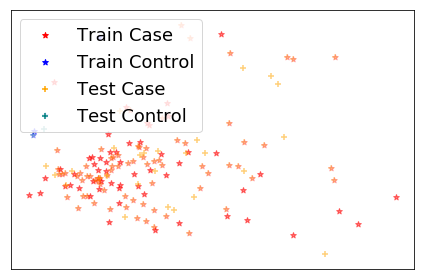

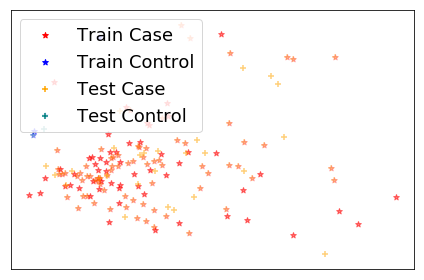

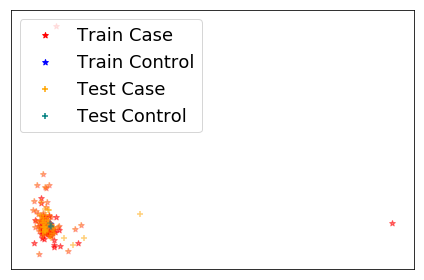

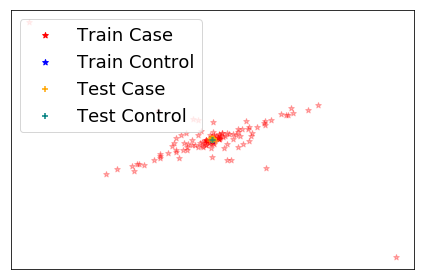

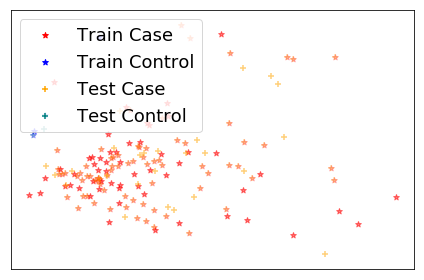

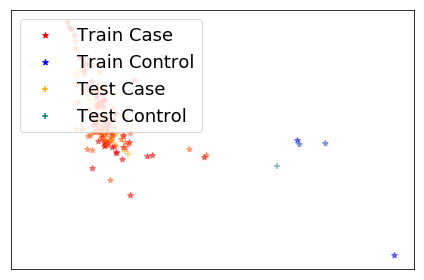

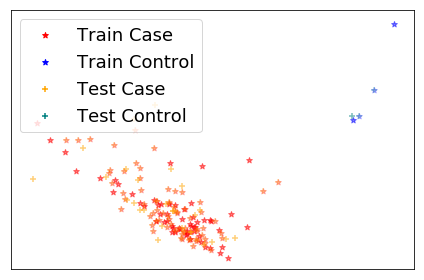

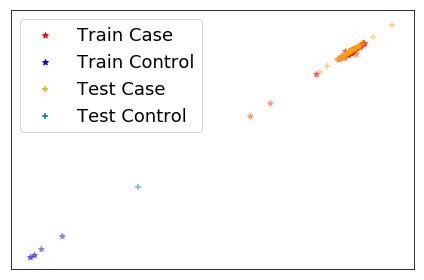

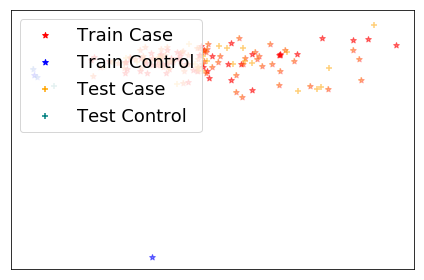

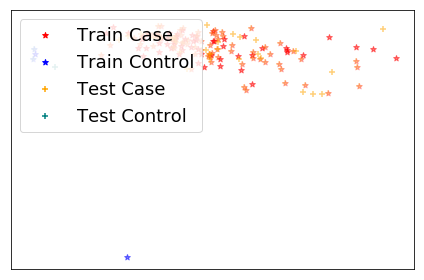

In [25]:
def plot_clusts(fg_train, bg_train, fg_test, bg_test, name):
    fig = plt.figure()
    plt.scatter(fg_train[:, 0], fg_train[:, 1], marker='*', color='red', label='Train Case', alpha=0.3)
    plt.scatter(bg_train[:, 0], bg_train[:, 1], marker='*', color='blue', label='Train Control', alpha=0.3)
    plt.scatter(fg_test[:, 0], fg_test[:, 1], marker='+', color='orange', label='Test Case', alpha=0.3)
    plt.scatter(bg_test[:, 0], bg_test[:, 1], marker='+', color='teal', label='Test Control', alpha=0.3)
    points = np.vstack((fg_test, bg_test))
    #plt.annotate("Test Sil: {:.3f}".format(silhouette_score(points, test_labels)),
    #    (np.min(points[:, 0]), np.max(points[:, 1])))
    plt.xticks([])
    plt.yticks([])
    lgd = plt.legend(fontsize=18, loc='upper left')
    for lh in lgd.legendHandles:
        lh.set_alpha(1.0)
    plt.tight_layout()
    plt.savefig("{}/Results/Clusters/{}_{}.png".format(cancer_type, fname_base, name))

if plot_clusters:
    helper = lambda train, test, name: plot_clusts(train[:n_train_fg, :2], train[n_train_fg:, :2],
                                            test[:n_fg-n_train_fg, :2], test[n_fg-n_train_fg:, :2], name)
    for (train, test, components, name) in reduced:
        helper(train, test, name)

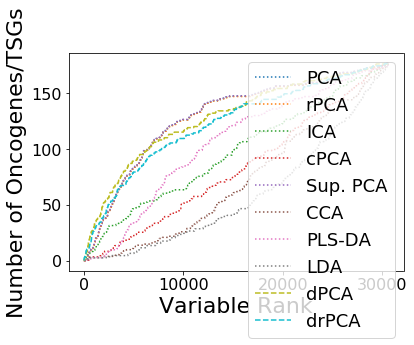

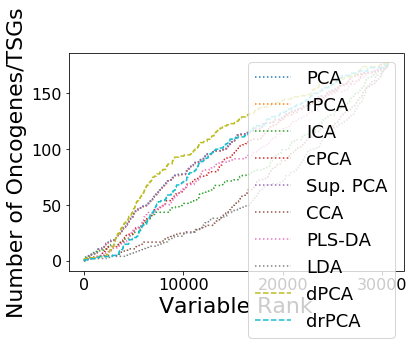

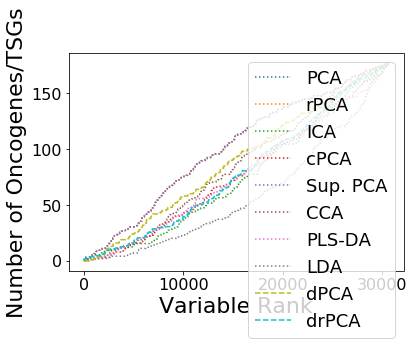

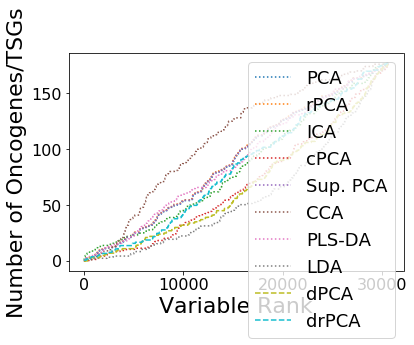

In [26]:
# Plot the Rank Curve
cosmic_genes = set([])
with open("cosmic_gene_census.tsv", 'r') as gene_census:
    for line in gene_census:
        cosmic_genes.add(line.split('\t')[0].upper())

def generate_curve(sorted_list):
    counts = []
    count = 0
    for (i, val) in sorted_list:
        if transcript_names[i].gene_name.upper() in cosmic_genes:
            count += 1
        counts.append(count)
    return counts

def plot_list_top(n):
    sort_helper = lambda components: [i for i in sorted(enumerate(np.sum(components[:n], axis=0)), key=lambda x: np.abs(x[1]), reverse=True)]
    sorted_components = [sort_helper(components) for (train, test, components, name) in reduced]

    def write_to_file(sorted_components, name):
        os.makedirs("{}/Results/Components/{}".format(cancer_type, name), exist_ok=True)
        with open("{}/Results/Components/{}/{}_{}_top_{}.csv".format(cancer_type, name, fname_base, name, n), 'w') as csv_file:
            with open("{}/Results/Components/{}/{}_{}_top_{}.tsv".format(cancer_type, name, fname_base, name, n), 'w') as tsv_file:
                for (idx, magnitude) in sorted_components:
                    print("{},{}".format(transcript_names[idx].gene_name, magnitude), file=csv_file)
                    print("{}\t{}".format(transcript_names[idx].gene_name, magnitude), file=tsv_file)

    if write_enrichment:
        for i, comps in enumerate(sorted_components):
            write_to_file(comps, reduced[i][-1])

    if plot_selection:
        fig = plt.figure()
        helper = lambda counts, name, linestyle: plt.plot(counts, label=name, linestyle=linestyle)
        for i, comps in enumerate(sorted_components):
            name = reduced[i][-1]
            if name == "drPCA" or name == "dsPCA" or name == "dPCA" or name == "dICA":
                helper(np.array(generate_curve(comps)) + np.random.uniform(0, 1), name, 'dashed')
            else:
                helper(np.array(generate_curve(comps)) + np.random.uniform(0, 1), name, 'dotted')
        plt.xlabel("Variable Rank", fontsize=22)
        plt.ylabel("Number of Oncogenes/TSGs", fontsize=22)
        ax = plt.gca()
        ax.tick_params(labelsize=16)
        plt.legend(fontsize=18)
        plt.savefig("{}/Results/oncogene_selection_top_{}_{}".format(cancer_type, n, fname_base))
    return sorted_components

if calc_onc_selection:
    sorted_components = plot_list_top(1)
    plot_list_top(2)
    plot_list_top(3)
    plot_list_top(5)

In [27]:
from sklearn.model_selection import RandomizedSearchCV
def calc_predictive(n_components=5):
    helper = lambda reps, labels, name: print("{}: {:.3f}".format(name,
        silhouette_score(reps[:, :n_components], labels)))
    print("="*20)
    print("Silhouette Scores, Training Data:")
    for (train, test, comps, name) in reduced:
        helper(train, train_labels, name)
    
    print('-'*20)
    print("Silhouette Scores, Testing Data:")
    for (train, test, comps, name) in reduced:
        helper(test, test_labels, name)
    print("="*20)

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start= 2, stop = 15, num = 3)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 20, num=5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    C_list = [0.01, 0.1, 0.5, 1., 2.5, 5.0, 10., 25.]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    lr_grid = {'C': C_list}
    def predict(x_train, x_test, y_train, y_test, calc_random):
        rf = RandomForestClassifier(n_estimators=3)
        clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
            n_iter=8, cv=2, verbose=0)

        clf.fit(x_train, y_train)
        #cross_validate(clf, x_train, y_train, return_train_score=False)

        if not test_tissue_type and not test_case_control:
            binarize = lambda x: label_binarize(x, classes=[0, 1, 2, 3, 4])
            auc_train = np.mean([roc_auc_score(binarize(y_train)[:, i], binarize(clf.predict(x_train))[:, i]) for i in range(5)])
            auc = np.mean([roc_auc_score(binarize(y_test)[:, i], binarize(clf.predict(x_test))[:, i]) for i in range(5)])
        else:
            auc_train = roc_auc_score(y_train, clf.predict(x_train), average='micro')
            auc = roc_auc_score(y_test, clf.predict(x_test))
        acc = accuracy_score(y_test, clf.predict(x_test))

        if calc_random:
            random_preds = np.ones_like(y_test)
            acc_random = 0.5 #accuracy_score(y_test, random_preds)
            auc_random = 0.5 #roc_auc_score(y_test, random_preds)
            return acc, auc, auc_train, acc_random, auc_random
        else:
            return acc, auc, auc_train

    if test_tissue_type:
        helper  = lambda train, test: predict(train[:n_train_fg, :n_components], test[:n_test_fg, :n_components], train_cancer_types, test_cancer_types, True)
    elif test_case_control:
        helper  = lambda train, test: predict(train[:, :n_components], test[:, :n_components], train_labels, test_labels, True)
    else:
        helper  = lambda train, test: predict(train[:n_train_fg, :n_components], test[:n_test_fg, :n_components], train_stages, test_stages, True)

    accs = []
    aucs = []
    aucs_train = []
    for (train_reduced, test_reduced, comps, name) in reduced:
        my_accs, my_auc, my_auc_train, accs_random, auc_random = helper(train_reduced, test_reduced)
        accs.append(my_accs)
        aucs.append(my_auc)
        aucs_train.append(my_auc_train)

    print("="*20)
    print("Case/Control AUC, Training Data")
    helper = lambda name, auc: print("{}: {:.3f}".format(name, auc))
    for i, auc_train in enumerate(aucs_train):
        helper(reduced[i][-1], auc_train)

    print("-"*20)
    print("Case/Control AUC, Testing Data")
    for i, auc in enumerate(aucs):
        helper(reduced[i][-1], auc)
    print("="*20)
    return aucs

N Components: 1
Silhouette Scores, Training Data:
PCA: 0.052
rPCA: 0.052
ICA: -0.478
cPCA: -0.588
Sup. PCA: 0.052
CCA: 0.901
PLS-DA: 0.774
LDA: 0.976
dPCA: 0.409
drPCA: 0.514
--------------------
Silhouette Scores, Testing Data:
PCA: 0.200
rPCA: 0.200
ICA: -0.269
cPCA: -0.063
Sup. PCA: 0.200
CCA: 0.890
PLS-DA: 0.767
LDA: 0.942
dPCA: 0.512
drPCA: 0.581
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.833
cPCA: 0.500
Sup. PCA: 0.917
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.984
--------------------
Case/Control AUC, Testing Data
PCA: 0.742
rPCA: 0.742
ICA: 0.742
cPCA: 0.500
Sup. PCA: 0.625
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.984
N Components: 2
Silhouette Scores, Training Data:
PCA: 0.292
rPCA: 0.292
ICA: -0.454
cPCA: -0.576
Sup. PCA: 0.292
CCA: 0.807
PLS-DA: 0.756
LDA: 0.976
dPCA: 0.638
drPCA: 0.668
--------------------
Silhouette Scores, Testing Data:
PCA: 0.186
rPCA: 0.186
ICA: -0.360
cPCA: -0.178
Sup. PCA: 0.186
CCA: 0.801
PLS-DA: 0.70

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.917
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 0.750
ICA: 0.625
cPCA: 0.996
Sup. PCA: 0.750
CCA: 0.750
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000
drPCA: 0.750
N Components: 13
Silhouette Scores, Training Data:
PCA: 0.425
rPCA: 0.425
ICA: -0.444
cPCA: -0.243
Sup. PCA: 0.426
CCA: 0.540
PLS-DA: 0.610
LDA: 0.975
dPCA: 0.422
drPCA: 0.466
--------------------
Silhouette Scores, Testing Data:
PCA: 0.404
rPCA: 0.404
ICA: -0.323
cPCA: 0.037
Sup. PCA: 0.404
CCA: 0.515
PLS-DA: 0.540
LDA: 0.941
dPCA: 0.368
drPCA: 0.381
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.833
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 0.750
ICA: 0.750
cPCA: 0.746
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 1.000
ICA: 0.750
cPCA: 1.000
Sup. PCA: 0.750
CCA: 0.750
PLS-DA: 0.742
LDA: 1.000
dPCA: 0.750
drPCA: 0.750
N Components: 24
Silhouette Scores, Training Data:
PCA: 0.362
rPCA: 0.362
ICA: 0.338
cPCA: -0.200
Sup. PCA: 0.362
CCA: 0.470
PLS-DA: 0.554
LDA: 0.966
dPCA: 0.336
drPCA: 0.390
--------------------
Silhouette Scores, Testing Data:
PCA: 0.375
rPCA: 0.376
ICA: 0.408
cPCA: 0.051
Sup. PCA: 0.376
CCA: 0.446
PLS-DA: 0.489
LDA: 0.931
dPCA: 0.321
drPCA: 0.337
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 0.750
ICA: 1.000
cPCA: 0.992
Sup. PCA: 0.750
CCA: 0.750
PLS-DA: 0.750
LDA: 1.000
dPCA: 1.000
d

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 0.750
ICA: 0.750
cPCA: 1.000
Sup. PCA: 0.750
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.750
drPCA: 1.000
N Components: 11
Silhouette Scores, Training Data:
PCA: 0.440
rPCA: 0.440
ICA: -0.441
cPCA: -0.251
Sup. PCA: 0.440
CCA: 0.558
PLS-DA: 0.627
LDA: 0.975
dPCA: 0.447
drPCA: 0.483
--------------------
Silhouette Scores, Testing Data:
PCA: 0.406
rPCA: 0.406
ICA: -0.324
cPCA: 0.138
Sup. PCA: 0.406
CCA: 0.537
PLS-DA: 0.557
LDA: 0.941
dPCA: 0.383
drPCA: 0.390
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 0.750
ICA: 0.750
cPCA: 0.996
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.992
LDA: 1.000
dPCA: 0.750

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 1.000
ICA: 0.750
cPCA: 0.996
Sup. PCA: 0.750
CCA: 0.750
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000
drPCA: 0.750
N Components: 22
Silhouette Scores, Training Data:
PCA: 0.375
rPCA: 0.375
ICA: 0.098
cPCA: -0.191
Sup. PCA: 0.375
CCA: 0.481
PLS-DA: 0.564
LDA: 0.969
dPCA: 0.349
drPCA: 0.401
--------------------
Silhouette Scores, Testing Data:
PCA: 0.387
rPCA: 0.388
ICA: -0.325
cPCA: 0.060
Sup. PCA: 0.388
CCA: 0.457
PLS-DA: 0.497
LDA: 0.934
dPCA: 0.330
drPCA: 0.343
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.750
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 1.000
ICA: 0.742
cPCA: 0.992
Sup. PCA: 0.750
CCA: 1.000
PLS-DA: 0.625
LDA: 1.000
dPCA: 1.000


Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 1.000
ICA: 0.750
cPCA: 0.746
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
N Components: 9
Silhouette Scores, Training Data:
PCA: 0.431
rPCA: 0.431
ICA: -0.434
cPCA: -0.261
Sup. PCA: 0.431
CCA: 0.575
PLS-DA: 0.645
LDA: 0.975
dPCA: 0.474
drPCA: 0.501
--------------------
Silhouette Scores, Testing Data:
PCA: 0.365
rPCA: 0.366
ICA: -0.329
cPCA: 0.150
Sup. PCA: 0.365
CCA: 0.551
PLS-DA: 0.574
LDA: 0.941
dPCA: 0.397
drPCA: 0.400
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.917
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 1.000
ICA: 0.625
cPCA: 0.746
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.992
LDA: 1.000
dPCA: 1.000


Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 1.000
ICA: 0.750
cPCA: 0.996
Sup. PCA: 0.750
CCA: 0.750
PLS-DA: 0.750
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
N Components: 20
Silhouette Scores, Training Data:
PCA: 0.388
rPCA: 0.389
ICA: 0.132
cPCA: -0.200
Sup. PCA: 0.389
CCA: 0.492
PLS-DA: 0.576
LDA: 0.972
dPCA: 0.362
drPCA: 0.412
--------------------
Silhouette Scores, Testing Data:
PCA: 0.390
rPCA: 0.391
ICA: -0.323
cPCA: 0.051
Sup. PCA: 0.391
CCA: 0.468
PLS-DA: 0.506
LDA: 0.938
dPCA: 0.338
drPCA: 0.351
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.833
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 0.750
ICA: 0.750
cPCA: 0.996
Sup. PCA: 1.000
CCA: 0.750
PLS-DA: 0.992
LDA: 1.000
dPCA: 0.750


Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.917
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 1.000
ICA: 0.750
cPCA: 0.738
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.984
LDA: 1.000
dPCA: 0.625
drPCA: 1.000
N Components: 7
Silhouette Scores, Training Data:
PCA: 0.416
rPCA: 0.416
ICA: -0.424
cPCA: -0.256
Sup. PCA: 0.416
CCA: 0.597
PLS-DA: 0.662
LDA: 0.976
dPCA: 0.503
drPCA: 0.530
--------------------
Silhouette Scores, Testing Data:
PCA: 0.339
rPCA: 0.339
ICA: -0.340
cPCA: 0.209
Sup. PCA: 0.339
CCA: 0.567
PLS-DA: 0.596
LDA: 0.942
dPCA: 0.421
drPCA: 0.420
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.917
cPCA: 0.917
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.914
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 1.000
ICA: 0.625
cPCA: 0.625
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.742
LDA: 1.000
dPCA: 0.750


Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 0.833
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 0.750
ICA: 0.750
cPCA: 0.750
Sup. PCA: 0.750
CCA: 0.750
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
N Components: 18
Silhouette Scores, Training Data:
PCA: 0.403
rPCA: 0.403
ICA: 0.175
cPCA: -0.256
Sup. PCA: 0.403
CCA: 0.505
PLS-DA: 0.586
LDA: 0.974
dPCA: 0.376
drPCA: 0.425
--------------------
Silhouette Scores, Testing Data:
PCA: 0.398
rPCA: 0.399
ICA: -0.325
cPCA: 0.018
Sup. PCA: 0.399
CCA: 0.479
PLS-DA: 0.515
LDA: 0.940
dPCA: 0.343
drPCA: 0.357
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 0.917
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 0.750
ICA: 0.750
cPCA: 0.621
Sup. PCA: 0.750
CCA: 0.750
PLS-DA: 0.976
LDA: 1.000
dPCA: 1.000


Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.833
cPCA: 0.833
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 1.000
ICA: 0.500
cPCA: 0.496
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
N Components: 5
Silhouette Scores, Training Data:
PCA: 0.461
rPCA: 0.461
ICA: -0.438
cPCA: -0.216
Sup. PCA: 0.461
CCA: 0.632
PLS-DA: 0.687
LDA: 0.976
dPCA: 0.560
drPCA: 0.565
--------------------
Silhouette Scores, Testing Data:
PCA: 0.377
rPCA: 0.377
ICA: -0.326
cPCA: 0.210
Sup. PCA: 0.377
CCA: 0.599
PLS-DA: 0.622
LDA: 0.942
dPCA: 0.463
drPCA: 0.450
Case/Control AUC, Training Data
PCA: 0.995
rPCA: 1.000
ICA: 0.833
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 1.000
rPCA: 1.000
ICA: 0.500
cPCA: 0.992
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000


Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.917
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 1.000
ICA: 0.625
cPCA: 0.746
Sup. PCA: 1.000
CCA: 0.750
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.750
N Components: 16
Silhouette Scores, Training Data:
PCA: 0.412
rPCA: 0.412
ICA: 0.227
cPCA: -0.245
Sup. PCA: 0.412
CCA: 0.518
PLS-DA: 0.595
LDA: 0.975
dPCA: 0.392
drPCA: 0.441
--------------------
Silhouette Scores, Testing Data:
PCA: 0.403
rPCA: 0.404
ICA: -0.327
cPCA: 0.026
Sup. PCA: 0.404
CCA: 0.495
PLS-DA: 0.524
LDA: 0.941
dPCA: 0.351
drPCA: 0.367
Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.995
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.750
rPCA: 0.750
ICA: 0.750
cPCA: 0.992
Sup. PCA: 0.750
CCA: 0.750
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000


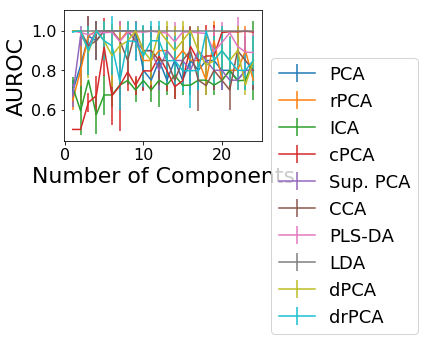

In [28]:
n_components_list = list(range(1, max_n_components))
n_iters = 5
n_methods = len(reduced)
results = np.zeros((n_methods, len(n_components_list), n_iters))
for n_iter in range(n_iters):
    for i, n_components in enumerate(n_components_list):
        print("N Components: {}".format(n_components))
        results[:, i, n_iter] = np.array(calc_predictive(n_components))

fig = plt.figure()
print("="*20)
print("Mean Case/Control AUC, Testing Data")
for i, (train, test, comps, name) in enumerate(reduced):
    if name == "Random":
        continue
    plt.errorbar(n_components_list, np.mean(results[i], axis=1), yerr=np.std(results[i], axis=1), label=name)
    print("{}:{:.3f}".format(name, np.mean(results[i])))
print("="*20)

plt.xlabel("Number of Components", fontsize=22)
plt.ylabel("AUROC", fontsize=22)
lgd = plt.legend(fontsize=18, bbox_to_anchor=(1, 0.7))
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("{}/Results/aucroc_{}.png".format(cancer_type, fname_base), dpi=300,
    bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()